In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/temp-ds-bowl-2019/labels_created
/kaggle/input/temp-ds-bowl-2019/df_counter_ini


In [2]:
import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
        
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
%time df = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv', engine='c')
# labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
df_test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')

df = reduce_mem_usage(df)
# labels = reduce_mem_usage(labels)
df_test = reduce_mem_usage(df_test)
specs = reduce_mem_usage(specs)

CPU times: user 1min 10s, sys: 11.3 s, total: 1min 22s
Wall time: 1min 22s
Mem. usage decreased to 778.73 Mb (18.2% reduction)
Mem. usage decreased to 79.40 Mb (18.2% reduction)
Mem. usage decreased to  0.01 Mb (0.0% reduction)


In [4]:
df_counter = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/df_counter_ini')
#df_counter = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/df_counter')
labels = pd.read_feather('/kaggle/input/temp-ds-bowl-2019/labels_created')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
display(df_counter.head(), labels.head())

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,correct
0,d122731b,3c96c025b64f4bd9,2019-07-23 17:09:00.809000+00:00,"{""correct"":true,""left"":[{""id"":""gem05"",""weight""...",554fc65a,73,4100,150271,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,True
1,93b353f2,70e401e4086e1864,2019-07-23 17:11:39.686000+00:00,"{""correct"":false,""pillars"":[],""event_count"":39...",554fc65a,39,4100,61900,Chest Sorter (Assessment),Assessment,CRYSTALCAVES,False
2,d122731b,d7cd15f8c2a14dbf,2019-07-23 20:08:27.864000+00:00,"{""correct"":false,""left"":[],""right"":[],""event_c...",76ed11ab,5,4100,4085,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,False
3,d122731b,d7cd15f8c2a14dbf,2019-07-23 20:08:32.180000+00:00,"{""correct"":false,""left"":[],""right"":[],""event_c...",76ed11ab,9,4100,8402,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,False
4,d122731b,d7cd15f8c2a14dbf,2019-07-23 20:08:37.875000+00:00,"{""correct"":false,""left"":[],""right"":[],""event_c...",76ed11ab,13,4100,14103,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,False


,game_session,world,type,timestamp,num_correct,total_attempts,installation_id,title,accuracy,num_incorrect,accuracy_group
0,00097cda27afb726,TREETOPCITY,Assessment,2019-09-15 16:37:00.433000+00:00,1,1,01bdd720,Mushroom Sorter (Assessment),1.000000,0,3
1,000f68cff32664ef,CRYSTALCAVES,Assessment,2019-10-12 23:08:24.584000+00:00,0,6,3f0dca37,Chest Sorter (Assessment),0.000000,6,0
2,0014403daadf67aa,TREETOPCITY,Assessment,2019-08-03 22:21:52.112000+00:00,1,4,29d1aaee,Bird Measurer (Assessment),0.250000,3,1
3,0014daa1d3e26eb2,TREETOPCITY,Assessment,2019-09-24 22:29:32.703000+00:00,1,3,55fdf49f,Mushroom Sorter (Assessment),0.333333,2,1
4,001c49e9e9968dbe,TREETOPCITY,Assessment,2019-07-26 15:50:54.148000+00:00,1,2,19d4b097,Bird Measurer (Assessment),0.500000,1,2


In [6]:
import gc
gc.collect()

22

# One user

## Prepare data for one user - create attempt and correct

In [7]:
#user_id, user = next(iter(df.groupby('installation_id')))
user_id = '29d1aaee' # '3f0dca37'
user = df[df.installation_id == user_id].copy()

totall_attempts = labels[labels.installation_id == user_id].total_attempts.sum()
totall_attempts

29

In [8]:
totall_assessments  = labels[labels.installation_id == user_id].shape[0]
totall_assessments

15

In [9]:
labels[labels.installation_id == user_id]

,game_session,world,type,timestamp,num_correct,total_attempts,installation_id,title,accuracy,num_incorrect,accuracy_group
2,0014403daadf67aa,TREETOPCITY,Assessment,2019-08-03 22:21:52.112000+00:00,1,4,29d1aaee,Bird Measurer (Assessment),0.25,3,1
1485,153db1a6821b651d,CRYSTALCAVES,Assessment,2019-07-30 00:57:51.035000+00:00,1,1,29d1aaee,Chest Sorter (Assessment),1.00,0,3
2387,22c97ceeea433c57,MAGMAPEAK,Assessment,2019-07-29 13:38:19.178000+00:00,1,1,29d1aaee,Cauldron Filler (Assessment),1.00,0,3
2982,2af5f41d0fa7ad7c,TREETOPCITY,Assessment,2019-07-29 13:53:46.052000+00:00,1,1,29d1aaee,Mushroom Sorter (Assessment),1.00,0,3
3062,2c4d69e7aff2c474,MAGMAPEAK,Assessment,2019-08-02 20:06:21.443000+00:00,1,2,29d1aaee,Cauldron Filler (Assessment),0.50,1,2
3404,314ad988e1dd241f,CRYSTALCAVES,Assessment,2019-08-06 21:02:47.094000+00:00,1,1,29d1aaee,Cart Balancer (Assessment),1.00,0,3
4438,412a7988647ba163,CRYSTALCAVES,Assessment,2019-08-04 03:12:50.490000+00:00,1,1,29d1aaee,Cart Balancer (Assessment),1.00,0,3
7211,69167d5f08433a1a,TREETOPCITY,Assessment,2019-07-29 14:06:17.200000+00:00,1,5,29d1aaee,Bird Measurer (Assessment),0.20,4,1
7268,69da6325084798aa,MAGMAPEAK,Assessment,2019-07-30 01:06:53.226000+00:00,1,1,29d1aaee,Cauldron Filler (Assessment),1.00,0,3
9194,85bd99e6ec026966,TREETOPCITY,Assessment,2019-08-03 02:32:46.608000+00:00,1,1,29d1aaee,Mushroom Sorter (Assessment),1.00,0,3


In [10]:
user['timestamp'] = pd.to_datetime(user['timestamp'])
print(user.shape)
user.sort_values(by='timestamp').head()

(6787, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1807351,27253bdc,e98c7b887e62411f,2019-07-28 21:25:32.823000+00:00,"{""event_code"": 2000, ""event_count"": 1}",29d1aaee,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
1807352,7d093bf9,c9ab9dfb7536c88d,2019-07-28 21:26:03.148000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",29d1aaee,1,2000,0,Chow Time,Game,CRYSTALCAVES
1807353,f93fc684,c9ab9dfb7536c88d,2019-07-28 21:26:12.151000+00:00,"{""coordinates"":{""x"":523,""y"":656,""stage_width"":...",29d1aaee,2,4010,9094,Chow Time,Game,CRYSTALCAVES
1807354,7ec0c298,c9ab9dfb7536c88d,2019-07-28 21:26:14.365000+00:00,"{""description"":""It's Chow Time! We have some V...",29d1aaee,3,3010,11310,Chow Time,Game,CRYSTALCAVES
1807355,0d1da71f,c9ab9dfb7536c88d,2019-07-28 21:26:24.744000+00:00,"{""description"":""It's Chow Time! We have some V...",29d1aaee,4,3110,21694,Chow Time,Game,CRYSTALCAVES


In [11]:
user['attempt'] = ((user.type == 'Assessment') &
                       (((user.event_code == 4100) & (user.title != 'Bird Measurer (Assessment)')) |
                        ((user.event_code == 4110)&(user.title == 'Bird Measurer (Assessment)')) )
                   ).astype('int8')
#attempt_idx = user[user.attempt == 1].index
assert user.attempt.sum() == totall_attempts

In [12]:
user['correct'] = 0
user.loc[user.attempt == 1, 'correct'] = user[user.attempt == 1].event_data.str.contains('"correct":true').astype('int8')
#user

### Info for last attemp

In [13]:
def check_data_on_empty(user_data, world, data_type):
    """
    params:
        user_data: dict - dict with data info about user. Keys already exist - installation_id, time_start
        world: str - world of current session
        data_type: str - "type" of current session
    """
    template = world +'_'+ data_type
    user_data[template+'_unique'] = user_data.get(template+'_unique', [])
    user_data[template+'_n_game_session'] = user_data.get(template+'_n_game_session', 0)
    user_data[template+'_event_count'] = user_data.get(template+'_event_count', 0)
    if data_type != 'Clip':
        user_data[template+'_game_time'] = user_data.get(template+'_game_time', 0)
    if  data_type == 'Assessment':
        user_data[world+'_num_correct'] = user_data.get(world+'_num_correct', 0)
        user_data[world+'_num_incorrect'] = user_data.get(world+'_num_incorrect', 0)
    
def get_common_data(session, user_data):
    """
    params: 
        session: DataFrame - one session form groupby('game_session')
        user_data: dict - dict with data info about user. Accumulate all infor for user though attempts.
    return:
        user_results: list - list of dictionaries, one for each attempt of one user
    """
    data_type = session.type.iloc[0]
    world = session.world.iloc[0]
    template = world +'_'+ data_type
    check_data_on_empty(user_data, world, data_type)    
     
    if data_type == 'Assessment' and session.correct.sum() == 1:  
        attempt = user_data.copy()
        #display(session)
        last_attempt_idx = session[session.correct ==1].index[0]
        attempt['last_attempt_world'] = session.world.iloc[0]
        attempt['last_attempt_game_time'] = session.at[last_attempt_idx, 'game_time']
        attempt['last_attempt_event_count'] = session.at[last_attempt_idx, 'event_count']
        
        # to labels
        attempt['num_correct'] = session.correct.sum()
        attempt['num_incorrect'] = session.attempt.sum() - attempt['num_correct']
        
        #print(world, user_data[world+'_num_incorrect'], attempt['num_incorrect'] )
        
        user_data[world+'_num_correct'] += attempt['num_correct'] 
        user_data[world+'_num_incorrect'] += attempt['num_incorrect'] #session.attempt.sum() - user_data[world+'_num_correct']
        #print('2', world, user_data[world+'_num_incorrect'])
        user_results.append(attempt)
    
    elif data_type == 'Assessment'  and session.correct.sum() > 1:
        print(session.game_session.iloc[0], ': game session; # correct attempt > 1')
    
    event_code_counts = session['event_code'].value_counts()
    for i, j in zip(event_code_counts.index, event_code_counts.values):
        user_data[i] = user_data.get(i,0) + j
        
    # add common info, include attempt info for next study
    user_data[template+'_unique'].extend(session.title.unique().tolist())
    user_data[template+'_n_game_session'] += np.unique(session.game_session).shape[0]
    user_data[template+'_event_count'] += session.shape[0]
    if data_type != 'Clip':
        user_data[template+'_game_time'] += session.game_time.max()
        
    return user_results


In [14]:
user_results = []

user_data = {}
user_data['installation_id'] = user.installation_id.iloc[0]
user_data['time_start'] = user.timestamp.iloc[0]

for i, session in user.groupby('game_session', sort=False):
    get_common_data(session, user_data)
    
tt = pd.DataFrame(user_results)

# Total: for all users

In [15]:
all_users = pd.DataFrame()

for user_id in labels.installation_id.unique():
    user = df[df.installation_id == user_id].copy()
    user['timestamp'] = pd.to_datetime(user['timestamp'])
    # user.sort_values(by='timestamp')
    
    user['attempt'] = ((user.type == 'Assessment') &
                       (((user.event_code == 4100) & (user.title != 'Bird Measurer (Assessment)')) |
                        ((user.event_code == 4110)&(user.title == 'Bird Measurer (Assessment)')) )
                   ).astype('int8')
    
    totall_attempts = labels[labels.installation_id == user_id].total_attempts.sum()
    assert user.attempt.sum() == totall_attempts
    
    user['correct'] = 0
    user.loc[user.attempt == 1, 'correct'] = user[user.attempt == 1]\
                                            .event_data.str.contains('"correct":true').astype('int8')

    user_results, user_data = [], {}
    
    user_data['installation_id'] = user.installation_id.iloc[0]
    user_data['time_start'] = user.timestamp.iloc[0]

    for i, session in user.groupby('game_session', sort=False):
        get_common_data(session, user_data)

    all_users = pd.concat((all_users,pd.DataFrame(user_results)), ignore_index=True, sort=False)
#     display(all_users)
#     input()
    
    

In [16]:
print(all_users.shape)
all_users.installation_id.unique().shape

(13461, 103)


(3157,)

In [17]:
all_users.columns

Index([                 'installation_id',                       'time_start',
                       'NONE_Clip_unique',         'NONE_Clip_n_game_session',
                  'NONE_Clip_event_count',                               2000,
               'CRYSTALCAVES_Clip_unique', 'CRYSTALCAVES_Clip_n_game_session',
          'CRYSTALCAVES_Clip_event_count',         'CRYSTALCAVES_Game_unique',
       ...
       'MAGMAPEAK_Assessment_event_count',   'MAGMAPEAK_Assessment_game_time',
                  'MAGMAPEAK_num_correct',          'MAGMAPEAK_num_incorrect',
                                     4230,                               4235,
                                     4220,                               4050,
                                     4080,                               4090],
      dtype='object', length=103)

In [18]:
all_users.columns = all_users.columns.astype(str)

In [19]:
all_users.to_pickle('all_users.pkl')

# Features names

In [20]:
worlds_columns = []
for world in df_test.world.unique():
    c = tt.columns
    worlds_columns.append([x for x in c if world in x])

TypeError: argument of type 'int' is not iterable

In [21]:
display(tt[['last_attempt_world',
      'num_correct', 'num_incorrect']], labels[labels.installation_id == user_id].sort_values(by='timestamp'))

,last_attempt_world,num_correct,num_incorrect
0,CRYSTALCAVES,1,0
1,CRYSTALCAVES,1,4
2,MAGMAPEAK,1,0
3,TREETOPCITY,1,0
4,TREETOPCITY,1,4
5,CRYSTALCAVES,1,0
6,MAGMAPEAK,1,0
7,MAGMAPEAK,1,1
8,TREETOPCITY,1,0
9,TREETOPCITY,1,3


,game_session,world,type,timestamp,num_correct,total_attempts,installation_id,title,accuracy,num_incorrect,accuracy_group
17675,ffbfa9bef569d593,CRYSTALCAVES,Assessment,2019-09-18 14:03:20.749000+00:00,0,2,a4e62501,Cart Balancer (Assessment),0.0,2,0


# Labels

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='deep')
sns.set_style("dark")

In [23]:
def autolabel(ratio, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for x, t in enumerate(ax.get_xticklabels()):
        f = t.get_text()
        try: f = int(f)
        except: pass
        ax.annotate(f'{ratio[f]:.2f}%',
                    xy=(x, 0),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

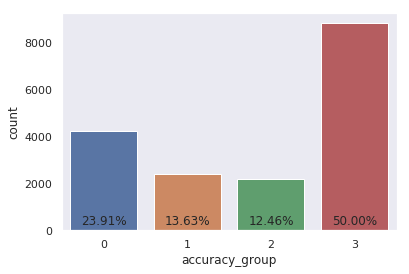

In [24]:
ax = sns.countplot(x='accuracy_group', data=labels);
autolabel(labels.accuracy_group.value_counts()/labels.shape[0]*100, ax)

# Features: title, type and world

In [25]:
# temp.world = temp.world.astype('category')
# print(temp.world.cat.categories)
# temp.world = temp.world.cat.codes

In [26]:
def df_na(df): return print("There aren't NaNs:",  ~df.isna().all(axis=None))

To compare inital train data with out labels, need to group inital data too

In [27]:
df_group = df.groupby('game_session', as_index=False).agg({'world': lambda x: x.iloc[0],
                                            'title': lambda x: x.iloc[0],
                                            'type': lambda x: x.iloc[0]})

Plot ditributions by categories for inital grouped data and labels_created data. Also for lables_created data plt distribution by accuracy_group

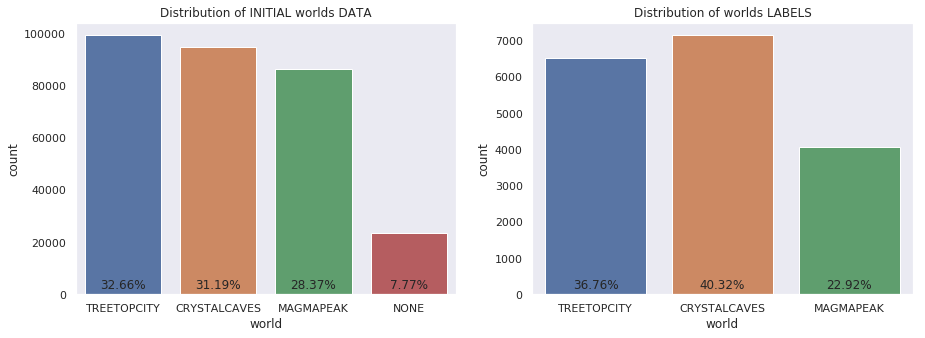

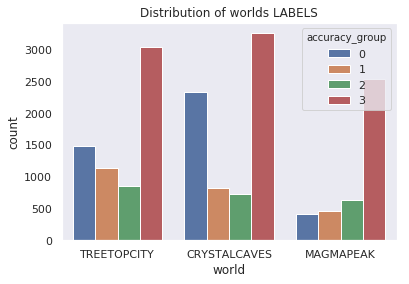

In [28]:
order = labels.world.unique()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='world', data=df_group , order=np.append(order, 'NONE'))
ax.set_title('Distribution of INITIAL worlds DATA')
autolabel(df_group.world.value_counts()/df_group.shape[0]*100, ax)

plt.subplot(1,2,2)
ax = sns.countplot(x='world', data=labels, order=order);
ax.set_title('Distribution of worlds LABELS');
autolabel(labels.world.value_counts()/labels.shape[0]*100, ax)

plt.show()

ax = sns.countplot(x='world', data=labels, hue='accuracy_group', order=order);
ax.set_title('Distribution of worlds LABELS');

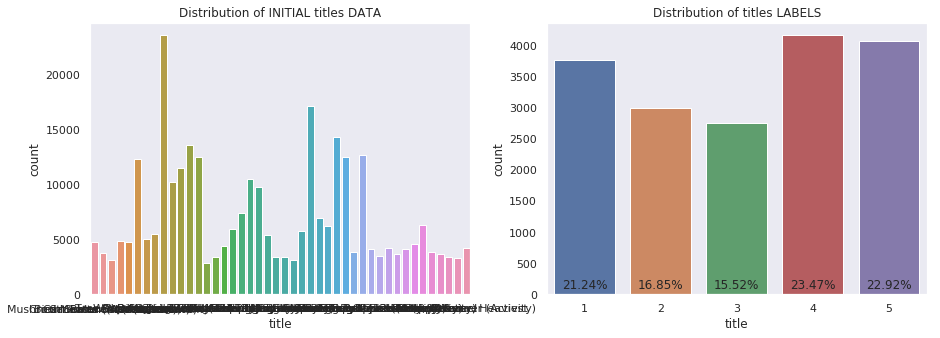

['Mushroom Sorter (Assessment)' 'Chest Sorter (Assessment)'
 'Bird Measurer (Assessment)' 'Cart Balancer (Assessment)'
 'Cauldron Filler (Assessment)']


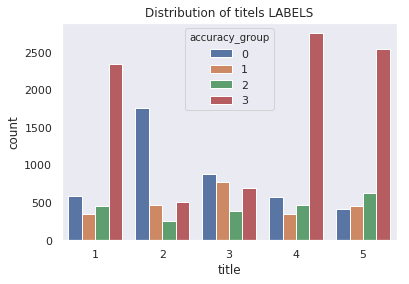

In [29]:
order = labels.title.unique()
leaved_cat = np.isin(df_group.title.unique(), order)
leaved_cat = df_group.title.unique()[~leaved_cat]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='title', data=df_group , order=np.append(order, leaved_cat))
ax.set_title('Distribution of INITIAL titles DATA')
#autolabel(df.title.value_counts()/df.shape[0]*100, ax)

plt.subplot(1,2,2)
ax = sns.countplot(x='title', data=labels, order=order);
ax.set_title('Distribution of titles LABELS');
autolabel(labels.title.value_counts()/labels.shape[0]*100, ax)
ax.set_xticklabels(['1','2','3','4','5'])

plt.show()

ax = sns.countplot(x='title', data=labels, hue='accuracy_group', order=order);
ax.set_title('Distribution of titels LABELS');
ax.set_xticklabels(['1','2','3','4','5']);
print(order)

**Note:** One can see for title 2 = 'Chest Sorter (Assessment)' most of samples have *accuracy_group* = 0 despire *accuracy_group* = 3 is majority class.

In [30]:
title_unique = labels.title.unique()

# counters for each title_name
counter_title = {'title': [lambda x,y=t: np.sum(x==y) for t in title_unique]}
# last title name
counter_title['title'].append(lambda x: x.iloc[-1])

counter_title.update({'game_session':'count',
                      'timestamp': lambda x: x.iloc[-1]})
counter_title

{'title': [<function __main__.<listcomp>.<lambda>(x, y='Mushroom Sorter (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Chest Sorter (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Bird Measurer (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Cart Balancer (Assessment)')>,
  <function __main__.<listcomp>.<lambda>(x, y='Cauldron Filler (Assessment)')>,
  <function __main__.<lambda>(x)>],
 'game_session': 'count',
 'timestamp': <function __main__.<lambda>(x)>}

In [31]:
columns = ['installation_id', 'title_MS', 'title_CS', 'title_BM', 'title_CB', 'title_CF', 'title_last',
       'n_games', 'timestamp_last']
labels_title = labels.sort_values(by='timestamp').groupby('installation_id', as_index=False)\
                     .agg(counter_title)
labels_title.columns = columns

labels_title.head()

,installation_id,title_MS,title_CS,title_BM,title_CB,title_CF,title_last,n_games,timestamp_last
0,0006a69f,3,0,2,0,0,Bird Measurer (Assessment),5,2019-08-06 20:50:12.115000+00:00
1,0006c192,1,0,1,0,1,Bird Measurer (Assessment),3,2019-10-01 00:59:42.289000+00:00
2,00129856,0,0,1,0,0,Bird Measurer (Assessment),1,2019-09-22 16:32:43.121000+00:00
3,001d0ed0,2,1,1,1,0,Chest Sorter (Assessment),5,2019-09-05 14:29:12.756000+00:00
4,00225f67,0,0,1,0,0,Bird Measurer (Assessment),1,2019-10-06 00:05:17.305000+00:00


# Look closer on one user

In [32]:
user_id = df_counter.installation_id.value_counts().idxmax()
user_id

'08987c08'

In [33]:
# check that user exists in labels
labels[labels.installation_id == user_id].shape[0] != 0

True

In [34]:
# find all information for user
user = df[df.installation_id == user_id]
user = user.sort_values(by='timestamp')
user.head(), user.shape

(        event_id      game_session                 timestamp  \
 409058  27253bdc  5bc756debd97a313  2019-08-05T16:11:03.928Z   
 409059  27253bdc  534ed88b7459e313  2019-08-05T16:12:29.447Z   
 409060  27253bdc  bb1842c07b8e72da  2019-08-05T16:13:59.361Z   
 409061  27253bdc  65fd8a3d84e9b26a  2019-08-05T16:15:45.628Z   
 409062  27253bdc  e612b7bb56139114  2019-08-05T16:17:27.377Z   
 
                                     event_data installation_id  event_count  \
 409058  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409059  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409060  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409061  {"event_code": 2000, "event_count": 1}        08987c08            1   
 409062  {"event_code": 2000, "event_count": 1}        08987c08            1   
 
         event_code  game_time                    title  type world  
 409058        2000          0  Welcome to Lost Lagoon! 

In [35]:
user['timestamp'] = pd.to_datetime(user['timestamp'])
user.dtypes

event_id                        object
game_session                    object
timestamp          datetime64[ns, UTC]
event_data                      object
installation_id                 object
event_count                      int16
event_code                       int16
game_time                        int32
title                           object
type                            object
world                           object
dtype: object

In [36]:
last_attempt = df_counter[df_counter.installation_id == user_id].iloc[-1]
print(last_attempt.timestamp)

user = user[user.timestamp <= last_attempt.timestamp]
print(user.shape)

2019-09-29 02:33:50.007000+00:00
(11169, 11)


In [37]:
user

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
409058,27253bdc,5bc756debd97a313,2019-08-05 16:11:03.928000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409059,27253bdc,534ed88b7459e313,2019-08-05 16:12:29.447000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409060,27253bdc,bb1842c07b8e72da,2019-08-05 16:13:59.361000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409061,27253bdc,65fd8a3d84e9b26a,2019-08-05 16:15:45.628000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
409062,27253bdc,e612b7bb56139114,2019-08-05 16:17:27.377000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08987c08,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
...,...,...,...,...,...,...,...,...,...,...,...
420222,a8efe47b,f32d7e7f77862955,2019-09-29 02:33:46.505000+00:00,"{""weight"":1,""pillars"":[2],""coordinates"":{""x"":8...",08987c08,19,4030,13466,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420223,0db6d71d,f32d7e7f77862955,2019-09-29 02:33:47.640000+00:00,"{""weight"":1,""destination"":""Lightest"",""coordina...",08987c08,20,4020,14617,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420224,a8efe47b,f32d7e7f77862955,2019-09-29 02:33:48.424000+00:00,"{""weight"":3,""pillars"":[1,2],""coordinates"":{""x""...",08987c08,21,4030,15383,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
420225,0db6d71d,f32d7e7f77862955,2019-09-29 02:33:48.757000+00:00,"{""weight"":3,""destination"":""Heavy"",""coordinates...",08987c08,22,4020,15733,Chest Sorter (Assessment),Assessment,CRYSTALCAVES
